# Model Training

In this notebooks, we formulate a multi-class classification problem as follows:

> Is a machine going to need maintenance within the next N cycles, and if yes, due to what type of a failure?

First, we define the future horizon:

In [1]:
%matplotlib inline
import glob
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.externals import joblib

data_dir = str(Path.home()) + '/data'

## Reading input data

In [2]:
filenames = glob.glob(data_dir + '/features/*.csv')
converters={"failure": str}
seed = 42
dfs= [pd.read_csv(filename, converters=converters) for filename in filenames]
data = pd.concat(dfs, ignore_index=True).fillna('')

## Train/test split

Two split strategies are implemented below:
* time-dependent split
* asset ID-based split

Time-dependent split is more complex as it requires that training and test data sets don't have common rolling feature time frames. This means that for all sequences in the test data set, $X$ immediately preceding entries need to be removed from the training data, where $X$ is the length of the rolling aggregation window used during feature engineering minus 1 [[2]](#ref_2).

In [3]:
lookback = 5       # rolling aggregation interval used during feature engineering
test_size = 0.2
time_split = False  # if set to False, will perform asset ID-based split

if time_split:
    data.set_index(['entryID'], inplace=True)
    data.sort_index(inplace=True)

    train, test = train_test_split(data, test_size=test_size, shuffle=False)
    
    min_cycles = test.reset_index().groupby(
        ['machineID']
    ).cycle.min().apply(lambda x: x - lookback).to_frame(name='max_cycle')
    
    t = train.reset_index().join(min_cycles, on='machineID')
    train = t[t.max_cycle.isna() |
              (t.cycle < t.max_cycle)].drop('max_cycle', axis=1)
    train.set_index(['entryID'], inplace=True)
else:
    # asset ID-based split
    unique_assets = data.reset_index().machineID.unique()
    train_assets, test_assets = train_test_split(
        unique_assets, test_size=test_size, random_state=seed)
    train = data[data.machineID.isin(train_assets)]
    test = data[data.machineID.isin(test_assets)]
    train.set_index(['entryID'], inplace=True)
    test.set_index(['entryID'], inplace=True)

In [4]:
def xy_split(data):
    data = data.reset_index(drop = True)
    columns_to_drop = ['cycle', 'immediate_failure', 'rul', 'sequenceID', 'machineID']
    return (data.drop(columns_to_drop, axis=1),
            data['immediate_failure'])

X_train, Y_train = xy_split(train)
X_test, Y_test = xy_split(test)

### Correction of data imbalance

In typical predictive maintenance data sets, positive examples as often underrepresented relative to negative examples. This can be seen by counting failure types in the "ground truth" training data set:

In [5]:
all_classes = Counter(Y_train)
majority_class = all_classes.most_common(1)
minority_classes = all_classes.most_common()[1:]

print('Majority class: ', majority_class)
print('Minority classes: ', minority_classes)

Majority class:  [('', 51971)]
Minority classes:  [('F1', 924), ('F2', 384)]


With class imbalance in data, performance of most standard learning algorithms is compromised, since they aim to minimize the overall error rate. For a data set with 99% negative and 1% positive examples, a model can be shown to have 99% accuracy by labeling all instances as negative. But the model will mis-classify all positive examples; so even if its accuracy is high, the algorithm is not a useful one.

Here, we will use the Synthetic Minority Over-sampling Technique (SMOTE) [[3]](#ref_3) to produce a more balanced training data set with at least 10% of positive examples. Note that over-sampling is not applied to the test data set.

In [6]:
minority_classes_size = sum([c[1] for c in minority_classes])
desired_minority_classes_size = Y_train.count() * 0.1

scale = desired_minority_classes_size / minority_classes_size

ratio = None
if scale > 1:
    ratio = dict((c[0], int(c[1] * scale)) for c in minority_classes)

sm = SMOTE(ratio=ratio, random_state=seed)
X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train)
Counter(Y_train_res)

Counter({'': 51971, 'F1': 3763, 'F2': 1564})

## Model training

Decision Trees are among the most popular and versatile classification methods. They work with both numerical and categorical data, and perform well even given relatively small training data sets.

Using decision trees within an ensemble (called Random Decision Forest) allows alleviating several problems:
* overfitting
* multi-collinearity

### Fitting the Random Forest classifier on the training data set

In [7]:
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_res, Y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Model evaluation

### Confusion matrix, precision, recall and F1 score

The easiest to visualize and interpret summary of a multi-class classifier's performance is the confusion matrix. This matrix is a juxtaposition of the classifier's predictions against the ground truth categories.

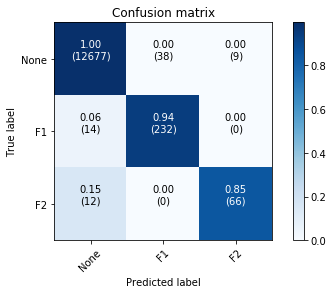

In [8]:
Y_predictions = clf.predict(X_test)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    orig = cm
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt) + '\n({0})'.format(orig[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#cm = confusion_matrix(Y_test, binarizer.inverse_transform(Y_predictions))
cm = confusion_matrix(Y_test, Y_predictions)
plot_confusion_matrix(cm, ['None'] + [c[0] for c in minority_classes])

For binary classification tasks, most of the classifier's performance measures can be derived directly from the entries of the standard two-by-two confusion matrix.

$$
\begin{matrix} 
 & Prediction=Negative & Prediction=Positive \\
Actual=Negative & \scriptsize True\ negatives\ (TN) & \scriptsize False\ positives (FP) \\
Actual=Positive & \scriptsize False\ netagives\ (FN) & \scriptsize True\ positives\ (TP) 
\end{matrix}
$$ 

Here are the definitions of several most common model performance measures:

| Measure | Formula |
|:--- |------|
| Precision |   $\frac{TP}{TP+FP}$  |
| Recall | $\frac{TP}{TP+FN}$ |
| F1 score | $\frac{2\cdot precision\cdot recall}{precision+recall}$ |

In a multi-class context, these measures are computed for each label independently and then averaged across the entire set of classes (as demonstrated in the classification report below).

In [9]:
print(classification_report(Y_test, Y_predictions, digits=4))

             precision    recall  f1-score   support

                0.9980    0.9963    0.9971     12724
         F1     0.8593    0.9431    0.8992       246
         F2     0.8800    0.8462    0.8627        78

avg / total     0.9946    0.9944    0.9945     13048



Note: ```classification_report``` function computes the averages taking class imbalance into account; for that reason, they are heavily biased towards the majority class.

### Accuracy

In general, *accuracy* is an inappropriate measure for unbalanced classes. To demonstrate that, let's compare the accuracy of our model against that of a dummy classifier (sometimes called a *null* model) which always returns the most frequent class.

In [10]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_res, Y_train_res)
Y_dummy = dummy.predict(X_test)

print('Accuracy scores')
print('Trained model: {0}\nDummy classifier: {1}'.format(accuracy_score(Y_test, Y_predictions),
                                                         accuracy_score(Y_test, Y_dummy)))

Accuracy scores
Trained model: 0.9944052728387492
Dummy classifier: 0.9751686082158185


With respect to accuracy, the trained model only slightly outperforms a dummy classifier.

### Area Under the Curve (AUC)

AUC is the area under the *receiver operating characteristic curve* (ROC curve), which is 1.0 for ideal classifiers and 0.5 for those that do no better than random guessing. Let's compare the AUC score of the trained model with that of the dummy classifier.

In [11]:
# roc_auc_score expects binarized labels
binarizer = LabelBinarizer()
binarizer.fit(Y_train_res)
Y_test_binarized = binarizer.transform(Y_test)

def auc_score(y_true, y_pred):
    return roc_auc_score(binarizer.transform(y_true), binarizer.transform(y_pred), average='macro')

print('ROC AUC scores')
print('Trained model: {0}\nDummy classifier: {1}'.format(auc_score(Y_test, Y_predictions),
                                                         auc_score(Y_test, Y_dummy)))

ROC AUC scores
Trained model: 0.9502733935438122
Dummy classifier: 0.5


ROC AUC score would be good candidate when a single sensitive model evaluation measure is needed.

## Persisting the model and input sample

In [12]:
joblib.dump(clf, 'model.pkl') 

['model.pkl']

In [13]:
sample = X_test.sample(n = 5).to_json(orient='records')
print('Sample:', sample)

with open('sample.json', 'w') as sample_file:
    sample_file.write(sample)

Sample: [{"s1":1000,"s2":1022.6876111111,"s3":137.4747777778,"s4":137.58,"s5":1388.8037222222,"s6":1559.73,"s7":137.3947361111,"s8":137.505,"s9":1409.3883599537,"s10":1561.185},{"s1":1000,"s2":748.101,"s3":140.986,"s4":141.1,"s5":959.5683333333,"s6":1396.75,"s7":140.8330981481,"s8":140.9516666667,"s9":1110.4324037037,"s10":1401.125},{"s1":1000,"s2":761.0606666667,"s3":137.4818333333,"s4":137.58,"s5":1073.3493333333,"s6":1543.29,"s7":137.4045476852,"s8":137.5116666667,"s9":1292.0819180556,"s10":1545.375},{"s1":1000,"s2":1017.40275,"s3":135.556875,"s4":135.67,"s5":1423.6099166667,"s6":1553.29,"s7":135.5155046296,"s8":135.6216666667,"s9":1337.8370324074,"s10":1554.4083333333},{"s1":1000,"s2":987.7542777778,"s3":136.0816111111,"s4":136.19,"s5":1370.1871666667,"s6":1538.23,"s7":136.0294351852,"s8":136.135,"s9":1299.7469675926,"s10":1539.35}]


## References

https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance#time-dependent-split

https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/chawla2002.html

http://scikit-learn.org/stable/modules/model_evaluation.html#